In [7]:
import os
import sys
import time
import random
import pandas as pd
from pathlib import Path
import numpy as np
import torch

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

from side_info_decoding.utils import (
    set_seed, 
    load_data_from_pids, 
    sliding_window_over_trials
)
from side_info_decoding.reduced_rank import (
    Multi_Task_Reduced_Rank_Model, 
    train_multi_task, 
    model_eval
)

seed = 666
set_seed(seed)

In [2]:
%matplotlib inline
plt.rc("figure", dpi=100)
SMALL_SIZE = 10
BIGGER_SIZE = 15
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('axes', linewidth=2)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=2)
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 10
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.size'] = 10

In [11]:
pids = [
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    "febb430e-2d50-4f83-87a0-b5ffbb9a4943",
    "523f8301-4f56-4faf-ab33-a9ff11331118",
    "84bb830f-b9ff-4e6b-9296-f458fb41d160",
    '0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a',
    '143dd7cf-6a47-47a1-906d-927ad7fe9117',
    '16799c7a-e395-435d-a4c4-a678007e1550',
    '1a60a6e1-da99-4d4e-a734-39b1d4544fad',
    '1e176f17-d00f-49bb-87ff-26d237b525f1',
    '31f3e083-a324-4b88-b0a4-7788ec37b191'
]

In [24]:
X_dict, Y_dict = load_data_from_pids(
    pids,
    brain_region="vis",
    behavior="choice",
    data_type="all_ks",
    n_t_bins = 30
)

pulling data from ibl database ..
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
number of trials found: 265 (active: 265)
prior for this session is not found.
found 265 trials from 17.56 to 2310.24 sec.
found 29 Kilosort units in region vis


Compute spike count: 100%|██████████████████| 265/265 [00:00<00:00, 5713.31it/s]


pulling data from ibl database ..
eid: db4df448-e449-4a6f-a0e7-288711e7a75a
pid: febb430e-2d50-4f83-87a0-b5ffbb9a4943
number of trials found: 230 (active: 230)
prior for this session is not found.
found 230 trials from 40.81 to 2252.10 sec.
found 29 Kilosort units in region vis


Compute spike count: 100%|██████████████████| 230/230 [00:00<00:00, 7326.52it/s]


pulling data from ibl database ..
eid: 88224abb-5746-431f-9c17-17d7ef806e6a
pid: 523f8301-4f56-4faf-ab33-a9ff11331118
number of trials found: 300 (active: 300)
prior for this session is not found.
found 300 trials from 37.78 to 2123.22 sec.
found 1 Kilosort units in region vis


Compute spike count: 100%|█████████████████| 300/300 [00:00<00:00, 13754.07it/s]


pulling data from ibl database ..
eid: c7248e09-8c0d-40f2-9eb4-700a8973d8c8
pid: 84bb830f-b9ff-4e6b-9296-f458fb41d160
number of trials found: 397 (active: 397)
prior for this session is not found.
found 397 trials from 17.65 to 3851.03 sec.
found 245 Kilosort units in region vis


Compute spike count: 100%|███████████████████| 397/397 [00:00<00:00, 823.62it/s]


pulling data from ibl database ..
eid: a4a74102-2af5-45dc-9e41-ef7f5aed88be
pid: 0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a
number of trials found: 293 (active: 293)
prior for this session is not found.
found 293 trials from 69.71 to 1849.44 sec.
found 69 Kilosort units in region vis


Compute spike count: 100%|██████████████████| 293/293 [00:00<00:00, 3078.57it/s]


pulling data from ibl database ..
eid: 3638d102-e8b6-4230-8742-e548cd87a949
pid: 143dd7cf-6a47-47a1-906d-927ad7fe9117
number of trials found: 283 (active: 283)
prior for this session is not found.
found 283 trials from 42.00 to 4761.48 sec.
found 10 Kilosort units in region vis


Compute spike count: 100%|█████████████████| 283/283 [00:00<00:00, 17325.26it/s]


pulling data from ibl database ..
eid: 0a018f12-ee06-4b11-97aa-bbbff5448e9f
pid: 16799c7a-e395-435d-a4c4-a678007e1550
number of trials found: 228 (active: 228)
prior for this session is not found.
found 228 trials from 142.29 to 2526.63 sec.
found 114 Kilosort units in region vis


Compute spike count: 100%|██████████████████| 228/228 [00:00<00:00, 2657.06it/s]


pulling data from ibl database ..
eid: 51e53aff-1d5d-4182-a684-aba783d50ae5
pid: 1a60a6e1-da99-4d4e-a734-39b1d4544fad
number of trials found: 293 (active: 293)
prior for this session is not found.
found 293 trials from 20.56 to 2602.49 sec.
found 51 Kilosort units in region vis


Compute spike count: 100%|██████████████████| 293/293 [00:00<00:00, 3538.22it/s]


pulling data from ibl database ..
eid: a8a8af78-16de-4841-ab07-fde4b5281a03
pid: 1e176f17-d00f-49bb-87ff-26d237b525f1
number of trials found: 333 (active: 333)
prior for this session is not found.
found 333 trials from 129.08 to 3563.50 sec.
found 72 Kilosort units in region vis


Compute spike count: 100%|██████████████████| 333/333 [00:00<00:00, 4744.59it/s]


pulling data from ibl database ..
eid: 61e11a11-ab65-48fb-ae08-3cb80662e5d6
pid: 31f3e083-a324-4b88-b0a4-7788ec37b191
number of trials found: 529 (active: 529)


/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/brainbox/behavior/wheel.py:84: RuntimeWarning: divide by zero encountered in true_divide
  vel = dp / dt


prior for this session is not found.
found 529 trials from 106.48 to 4366.14 sec.
found 61 Kilosort units in region vis


Compute spike count: 100%|██████████████████| 529/529 [00:00<00:00, 1979.15it/s]


In [25]:
# an example of model training and eval

start_time = time.time()

example_pid = pids[0]

R = 2 # rank
d = 0 # half window size
n_epochs = 7000

# prepare data
n_units = []
train_X_lst, train_Y_lst, test_X_lst, test_Y_lst = [], [], [], []
for pid in pids:
    X, Y = X_dict[pid], Y_dict[pid]
    K, C, T = X.shape
    X = sliding_window_over_trials(X, half_window_size=d)
    Y = sliding_window_over_trials(Y, half_window_size=d)
    X, Y = torch.tensor(X), torch.tensor(Y)
    train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=seed)
    train_X_lst.append(train_X)
    train_Y_lst.append(train_Y)
    test_X_lst.append(test_X)
    test_Y_lst.append(test_Y)
    n_units.append(C)

    
multi_task_rrm = Multi_Task_Reduced_Rank_Model(
    n_tasks=len(pids),
    n_units=n_units, 
    n_t_bins=T, 
    rank=R, 
    half_window_size=d
)

# training
rrm, train_losses = train_multi_task(
    model=multi_task_rrm,
    train_dataset=(train_X_lst, train_Y_lst),
    test_dataset=(test_X_lst, test_Y_lst),
    loss_function=torch.nn.BCELoss(),
    learning_rate=1e-3,
    weight_decay=1e-3,
    n_epochs=n_epochs,
)

# eval
test_U, test_V, test_metrics = model_eval(
    multi_task_rrm, 
    train_dataset=(train_X_lst, train_Y_lst),
    test_dataset=(test_X_lst, test_Y_lst),
    model_type="multi_task", 
    behavior="choice"
)

end_time = time.time()
print(f"time spent: {end_time - start_time: .3f} seconds")

Epoch [700/7000], Loss: 6.595625632153812
Epoch [1400/7000], Loss: 0.5704276848777556
Epoch [2100/7000], Loss: 0.4049556505894175
Epoch [2800/7000], Loss: 0.29631121583443465
Epoch [3500/7000], Loss: 0.2076673435459758
Epoch [4200/7000], Loss: 0.16703484967318227
Epoch [4900/7000], Loss: 0.15045862576232288
Epoch [5600/7000], Loss: 0.14249540466003244
Epoch [6300/7000], Loss: 0.1382043509207354
Epoch [7000/7000], Loss: 0.13560383451924185
task 0 train accuracy: 1.000 auc: 1.000
task 0 test accuracy: 0.698 auc: 0.639
task 1 train accuracy: 1.000 auc: 1.000
task 1 test accuracy: 0.804 auc: 0.885
task 2 train accuracy: 0.537 auc: 0.529
task 2 test accuracy: 0.483 auc: 0.490
task 3 train accuracy: 1.000 auc: 1.000
task 3 test accuracy: 0.838 auc: 0.915
task 4 train accuracy: 1.000 auc: 1.000
task 4 test accuracy: 0.915 auc: 0.982
task 5 train accuracy: 0.770 auc: 0.837
task 5 test accuracy: 0.544 auc: 0.583
task 6 train accuracy: 1.000 auc: 1.000
task 6 test accuracy: 0.761 auc: 0.858
task

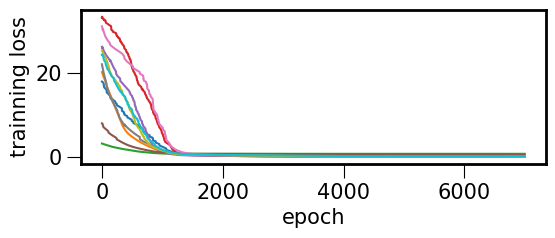

In [27]:
plt.figure(figsize=(6,2))
plt.plot(train_losses)
plt.xlabel("epoch")
plt.ylabel("trainning loss")
plt.show()

In [30]:
R = 2 # rank
d = 0 # half window size
n_epochs = 7000
n_folds = 5

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

n_units = []
train_X_dict, test_X_dict, train_Y_dict, test_Y_dict = {}, {}, {}, {}
for pid in pids:
    X, Y = X_dict[pid], Y_dict[pid]
    K, C, T = X.shape
    n_units.append(C)
    X = sliding_window_over_trials(X, half_window_size=d)
    Y = sliding_window_over_trials(Y, half_window_size=d)
    X, Y = torch.tensor(X), torch.tensor(Y)
    train_X_dict.update({pid: [X[train] for train, _ in skf.split(X, Y)]})
    test_X_dict.update({pid: [X[test] for _, test in skf.split(X, Y)]})
    train_Y_dict.update({pid: [Y[train] for train, _ in skf.split(X, Y)]})
    test_Y_dict.update({pid: [Y[test] for _, test in skf.split(X, Y)]})

In [31]:
# example of performing 5-fold CV on all sessions

start_time = time.time()

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

U_per_fold, V_per_fold, metrics_per_fold = [], [], []
for fold_idx in range(n_folds):
    
    print(f"start training fold {fold_idx+1} on {len(pids)} sessions ..")
    train_X_lst = [train_X_dict[pid][fold_idx] for pid in pids]
    test_X_lst = [test_X_dict[pid][fold_idx] for pid in pids]
    train_Y_lst = [train_Y_dict[pid][fold_idx] for pid in pids]
    test_Y_lst = [test_Y_dict[pid][fold_idx] for pid in pids]
    
    multi_task_rrm = Multi_Task_Reduced_Rank_Model(
        n_tasks=len(pids),
        n_units=n_units, 
        n_t_bins=T, 
        rank=R, 
        half_window_size=d
    )

    # training
    rrm, train_losses = train_multi_task(
        model=multi_task_rrm,
        train_dataset=(train_X_lst, train_Y_lst),
        test_dataset=(test_X_lst, test_Y_lst),
        loss_function=torch.nn.BCELoss(),
        learning_rate=1e-3,
        weight_decay=1e-1,
        n_epochs=n_epochs,
    )

    # eval
    test_U, test_V, test_metrics = model_eval(
        multi_task_rrm, 
        train_dataset=(train_X_lst, train_Y_lst),
        test_dataset=(test_X_lst, test_Y_lst),
        model_type="multi_task", 
        behavior="choice"
    )
    U_per_fold.append(test_U)
    V_per_fold.append(test_V)
    metrics_per_fold.append(test_metrics)

end_time = time.time()
print(f"time spent: {end_time - start_time: .3f} seconds")

start training fold 1 on 10 sessions ..
Epoch [700/7000], Loss: 7.052442381688183
Epoch [1400/7000], Loss: 1.7381245884462388
Epoch [2100/7000], Loss: 0.7754971926483479
Epoch [2800/7000], Loss: 0.5340386952331757
Epoch [3500/7000], Loss: 0.48658707720104466
Epoch [4200/7000], Loss: 0.47882523411367484
Epoch [4900/7000], Loss: 0.47645267021243887
Epoch [5600/7000], Loss: 0.4719693075320607
Epoch [6300/7000], Loss: 0.47008187664706363
Epoch [7000/7000], Loss: 0.4697657909393266
task 0 train accuracy: 0.759 auc: 0.681
task 0 test accuracy: 0.755 auc: 0.738
task 1 train accuracy: 0.902 auc: 0.956
task 1 test accuracy: 0.848 auc: 0.925
task 2 train accuracy: 0.517 auc: 0.511
task 2 test accuracy: 0.500 auc: 0.471
task 3 train accuracy: 0.905 auc: 0.973
task 3 test accuracy: 0.838 auc: 0.932
task 4 train accuracy: 0.923 auc: 0.985
task 4 test accuracy: 0.915 auc: 0.986
task 5 train accuracy: 0.686 auc: 0.741
task 5 test accuracy: 0.632 auc: 0.684
task 6 train accuracy: 0.901 auc: 0.978
task

In [32]:
Us, Vs, metrics_dict = {}, {}, {}
for pid_idx, pid in enumerate(pids):
    metrics_dict.update({pid: np.mean(metrics_per_fold, 0)[pid_idx]})
    Us.update({pid: [U_per_fold[fold_idx][pid_idx] for fold_idx in range(n_folds)]})
    Vs.update({pid: V_per_fold})

metrics_df = pd.DataFrame(metrics_dict).T
metrics_df.columns = ["accuracy", "auc"]
metrics_df

,accuracy,auc
dab512bd-a02d-4c1f-8dbc-9155a163efc0,0.750943,0.567564
febb430e-2d50-4f83-87a0-b5ffbb9a4943,0.830435,0.909126
523f8301-4f56-4faf-ab33-a9ff11331118,0.520000,0.476510
84bb830f-b9ff-4e6b-9296-f458fb41d160,0.823576,0.920267
0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a,0.894155,0.969121
143dd7cf-6a47-47a1-906d-927ad7fe9117,0.614850,0.651439
16799c7a-e395-435d-a4c4-a678007e1550,0.811594,0.893307
1a60a6e1-da99-4d4e-a734-39b1d4544fad,0.774459,0.872007
1e176f17-d00f-49bb-87ff-26d237b525f1,0.792402,0.897228
31f3e083-a324-4b88-b0a4-7788ec37b191,0.814717,0.892413


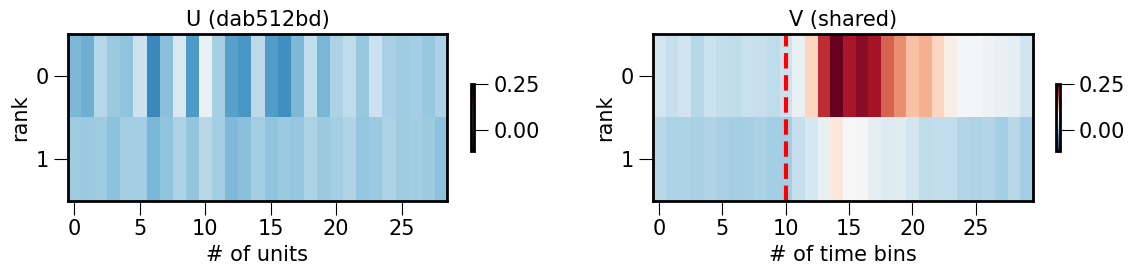

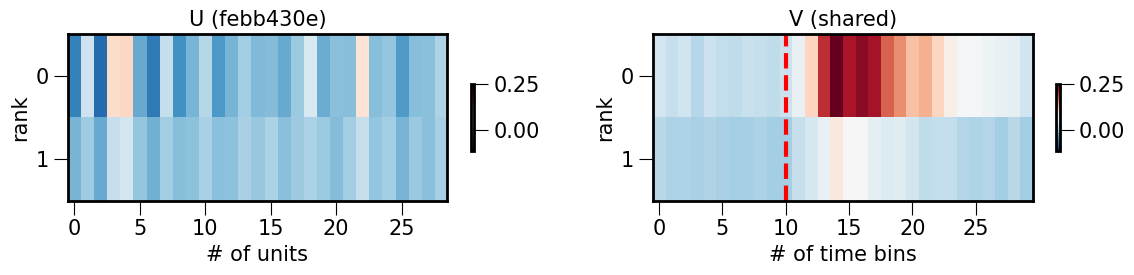

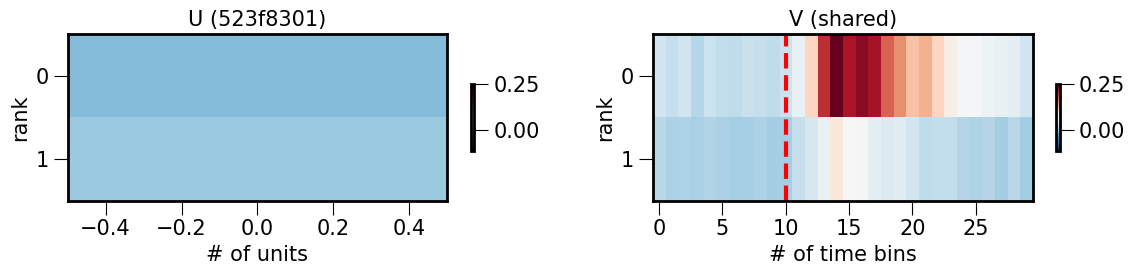

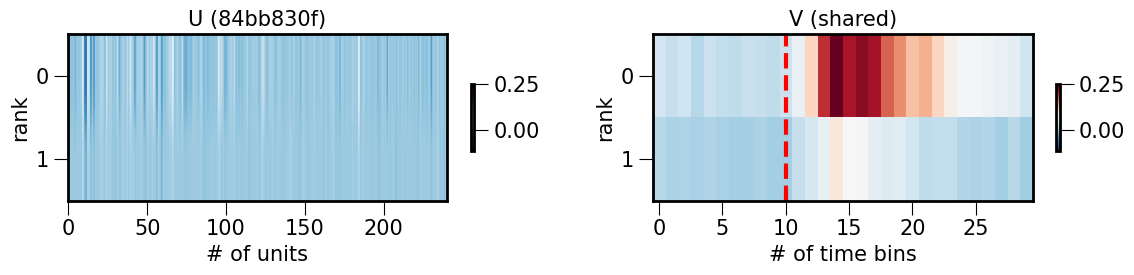

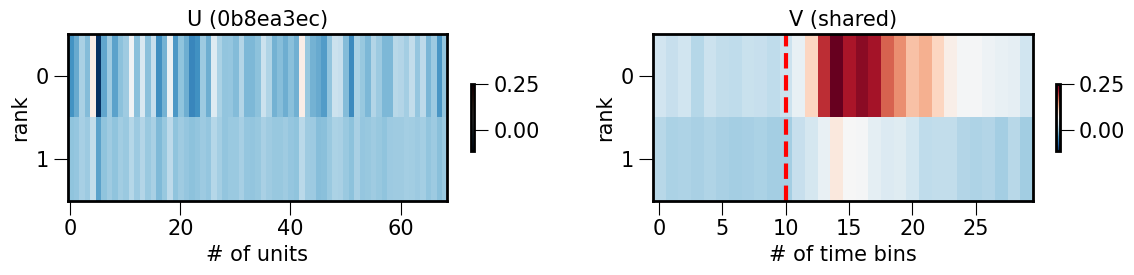

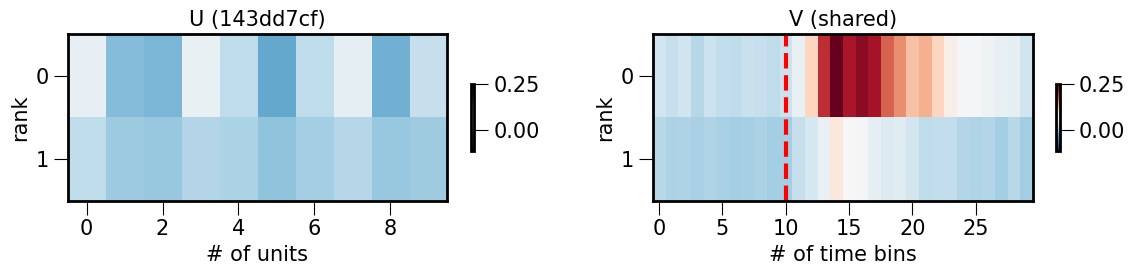

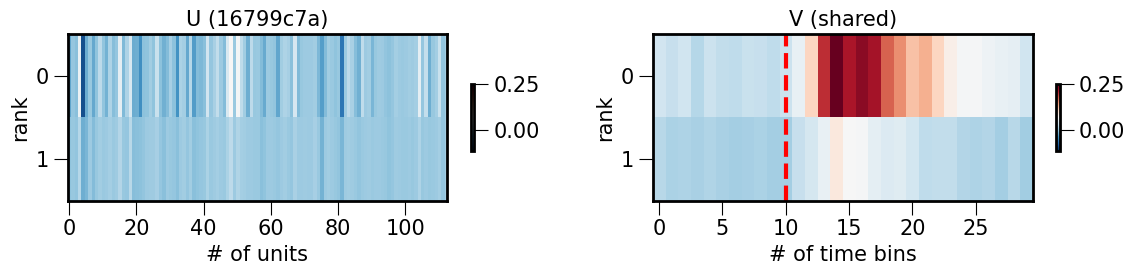

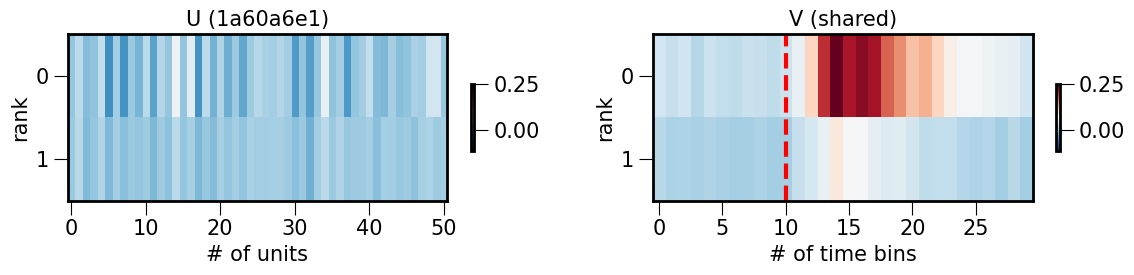

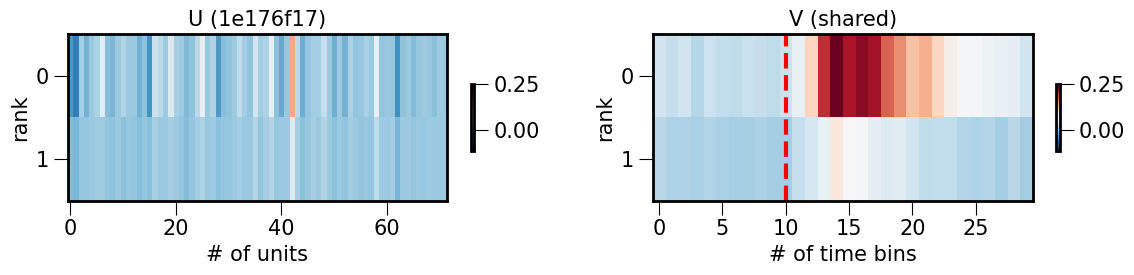

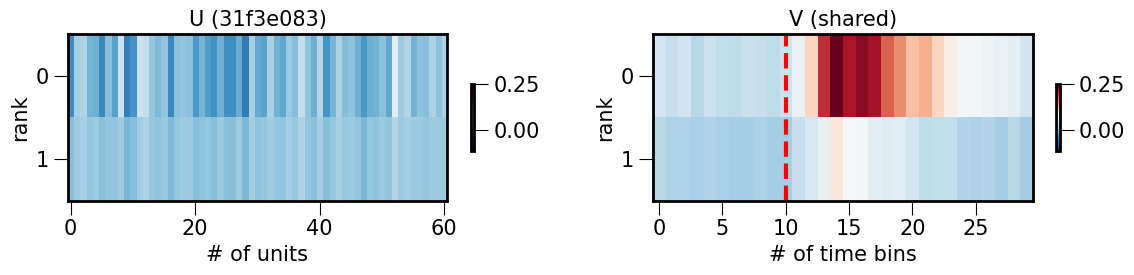

In [33]:
Us_plot, Vs_plot = [], []
for pid in pids:
    # average U and V across trials
    Us_plot.append(np.array(Us[pid]).mean(0))
    Vs_plot.append(np.array(Vs[pid]).mean(0).squeeze().T)
u_min, u_max = np.min(np.concatenate(Us_plot)), np.max(np.concatenate(Us_plot))
v_min, v_max = np.min(np.concatenate(Vs_plot)), np.max(np.concatenate(Vs_plot))
c_min, c_max = np.min([u_min, v_min]), np.max([u_max, v_max])
    
for pid_idx, pid in enumerate(pids):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 3))
    heatmap1 = ax1.imshow(Us_plot[pid_idx].T, aspect="auto", cmap="RdBu_r", vmin=c_min, vmax=c_max)
    heatmap2 = ax2.imshow(Vs_plot[pid_idx].T, aspect="auto", cmap="RdBu_r", vmin=c_min, vmax=c_max)
    ax2.axvline(x=10, c="red", linestyle="--", linewidth=3)
    cbar = fig.colorbar(heatmap1, ax=ax1, shrink=0.4)
    cbar = fig.colorbar(heatmap2, ax=ax2, shrink=0.4)
    ax1.set_ylabel("rank")
    ax1.set_xlabel("# of units")
    ax1.set_title(f"U ({pid[:8]})")
    ax2.set_ylabel("rank")
    ax2.set_xlabel("# of time bins")
    ax2.set_title(f"V (shared)")
    plt.tight_layout()